In [7]:
import sys
sys.path.append("../../components")

from videoinput.filevideoinput import VideoFileInputSource
from videoprocessinglayers import VideoProcessingLayer
#from layers.resizer import ResizerLayer
#from layers.writer import WriterLayer
#from layers.zmqpub import ZMQPubLayer
from videoprocessor import VideoProcessor

import numpy as np
import cv2

# Layers

In [58]:
import tensorflow as tf
from tensorflow_serving.apis import predict_pb2
from tensorflow_serving.apis import prediction_service_pb2_grpc
import grpc
import numpy as np
import requests
import cv2
import matplotlib.pyplot as plt


MODEL="febrero-cpu-friendly_weights"



class CrackDetectorLayer(VideoProcessingLayer):
    def __init__(self, model,endpoint='localhost:8500',patch_size=64,stride=16):
        VideoProcessingLayer.__init__(self)
        self.endpoint = endpoint
        self.model = model
        self.patch_size = patch_size
        self.stride = stride
        self.channel = grpc.insecure_channel(self.endpoint)
        
    def __del__(self):
        self.channel.close()
    
    def setup(self, ctx):        
        pass
    
    def process(self, ctx):
        boxes = self.scan_image(ctx["OUTPUT_FRAME"])
        print(boxes)
        self.draw_found_bounding_boxes(boxes)
        
        plt.imshow(ctx["OUTPUT_FRAME"])
        plt.show()
    
    def release(self, ctx):
        pass
    
    def scan_image(self,img):
        boxes = []    
        for x0 in range(0,int(img.shape[1])-self.patch_size,self.stride):
            for y0 in range(0,int(img.shape[0])-self.patch_size,self.stride):            
                x1 = x0 + self.patch_size
                y1 = y0 + self.patch_size
                subimg = img[y0:y1,x0:x1]                
                subimg_converted = subimg.reshape(1,self.patch_size,self.patch_size,3) 
                pred = self.predict_crack_or_no_crack(subimg)
                if pred[1]>=0.5:
                    boxes.append((x0,y0,x1,y1))
        return boxes
       
    def draw_found_bounding_boxes(self,boxes,color=(255,0,0)):
        for box in boxes:
            cv2.rectangle(ctx["OUTPUT_FRAME"], box[0:2], box[2:4], color, 2)
    
    def predict_crack_or_no_crack(self, subimg):        
        request = predict_pb2.PredictRequest()
        request.model_spec.name = MODEL
        request.model_spec.signature_name = 'serving_default'        
        image_np_expanded = np.expand_dims(subimg, axis=0).astype(np.float)
        input_tensor = tf.contrib.util.make_tensor_proto(
            image_np_expanded, dtype=tf.float32,shape=[1,subimg.shape[0], subimg.shape[1],3])
        request.inputs['input_image'].CopyFrom(input_tensor)
        stub = prediction_service_pb2_grpc.PredictionServiceStub(self.channel)
        result = stub.Predict(request, 10.0)  # 10 secs timeout
        return result.outputs["dense_12/Softmax:0"].float_val

## Pipeline

Opening input video
Starting process
Processing frame 1/1
[(0, 0, 64, 64), (16, 0, 80, 64), (16, 16, 80, 80), (16, 32, 80, 96), (32, 0, 96, 64), (32, 16, 96, 80), (32, 32, 96, 96), (48, 0, 112, 64), (48, 16, 112, 80), (48, 32, 112, 96), (48, 48, 112, 112), (48, 64, 112, 128), (64, 0, 128, 64), (64, 16, 128, 80), (64, 32, 128, 96), (64, 48, 128, 112), (64, 64, 128, 128), (64, 80, 128, 144), (64, 96, 128, 160), (80, 0, 144, 64), (80, 16, 144, 80), (80, 32, 144, 96), (80, 48, 144, 112), (80, 64, 144, 128), (80, 80, 144, 144), (80, 96, 144, 160), (96, 0, 160, 64), (96, 16, 160, 80), (96, 32, 160, 96), (96, 48, 160, 112), (96, 64, 160, 128), (96, 80, 160, 144), (96, 96, 160, 160), (112, 16, 176, 80), (112, 32, 176, 96), (112, 48, 176, 112), (112, 64, 176, 128), (112, 80, 176, 144), (112, 96, 176, 160), (256, 64, 320, 128), (256, 80, 320, 144), (256, 96, 320, 160), (256, 112, 320, 176), (272, 96, 336, 160), (288, 64, 352, 128), (288, 112, 352, 176), (304, 64, 368, 128), (304, 80, 368, 144), 

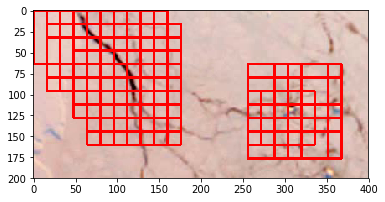

Processing finished


In [66]:
# Parameters
BASE_PATH="../../../"
INPUT_VIDEO_FILENAME = BASE_PATH+'media/wall-scan.avi'

ctx = {}

input_source = VideoFileInputSource( 
	filename=INPUT_VIDEO_FILENAME, start_frame=270, max_frames=1, repeat=False, interval=0.3 )

layers = [
    CrackDetectorLayer(model=MODEL)
] 

vp = VideoProcessor()
vp.process_video( ctx, input_source, layers )